# Binkowski: toy example
This is an toy example that demonstrates Binkowski's method.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

import itertools

import matplotlib.pyplot as plt

### Functions for generation and visualization of the image batches

In [2]:
def visualize_img_batch(batch):
    '''Visualizes image batch
    
    Parameters:
    batch (Tensor): An image batch
    '''
    grid = make_grid(batch.cpu(), nrow=8, padding=1, normalize=False, range=None, scale_each=False, pad_value=0)
    plt.imshow(grid.permute(1,2,0))
    plt.show()

In [3]:
def random_image_data(size=(2**21, 3, 1, 1), ratio=0.5, offset=0.2, color=0, std=0):
    '''Generates a random image batch 
    consisting of two modes (dark and light images)
    
    Parameters:
    size (tuple): The dimensions of the image batch (batch_size, channels, width, length)
    ratio (float): The ratio of light to dark images
    offset (float): The brightness of the images relative to black and bright
    color (int): Red = 0, green = 1, blue = 2
    std (float): the standard deviation of the noise in the data set
    
    Returns:
    image_batch (Tensor): The generated image batch
    
    '''
    idx = torch.randperm(size[0])[:int(ratio*size[0])] # Randomly choose indices according to the ratio
    
    m = torch.distributions.normal.Normal(torch.Tensor([0]), torch.ones((int(torch.prod(torch.Tensor(size)))))*std)
    
    image_batch = torch.zeros(size)
    image_batch[:, color] += offset # light color
    image_batch[idx, color] = 1 - offset # dark color 
    
    image_batch += m.sample().view(size)
    return image_batch.clamp(0, 1).cuda()

### The dataset class

In [4]:
class ColorDataset(Dataset):
    '''The dataloader for the color images
    '''
    def __init__(self, ratio=0.5, offset=0.2, color=0, std=0):
        '''  
        Parameters:
        ratio (float): The ratio of light to dark images
        offset (float): The brightness of the images relative to black and bright
        color (int): Red = 0, green = 1, blue = 2
        std (float): the standard deviation of the noise in the data set
        '''
        self.offset = offset
        self.ratio = ratio
        self.color = color
        self.std = std
        
        self.dataset = random_image_data(ratio=self.ratio, 
                                         offset=self.offset, 
                                         color=self.color,
                                         std=self.std)
        self.example_imgs = self.example()
        
    def example(self):
        '''
        Returns an example from each mode in the domain
        
        '''
        example_imgs = torch.zeros(size=(2, 3, 1, 1))

        example_imgs[0, self.color] += self.offset # light color
        example_imgs[1, self.color] = 1 - self.offset # dark color
        return example_imgs

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):      
        return self.dataset[idx]

### The networks

In [5]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.fc1 = nn.Linear(3, 1)
        self.fc2 = nn.Linear(1, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, 3)))
        out = self.fc2(h1)
        return out

In [6]:
class TrivialWeightNet(nn.Module):
    '''A trivial network that predicts the importances of the samples'''

    def __init__(self):
        super(TrivialWeightNet, self).__init__()
        self.fc1 = nn.Linear(1, 1)
        
    def forward(self, x):
        return torch.ones((x.shape[0], 1)).cuda()

In [7]:
class Discriminator(nn.Module):
    '''A simple joint discriminator network'''

    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1_A = nn.Linear(3, 3)
        self.fc1_B = nn.Linear(3, 3)
        self.fc2   = nn.Linear(6, 6)
        self.fc3   = nn.Linear(6, 1)
        self.dropout = nn.Dropout(1/6)
        
    def forward(self, x, y):
        h1_A = torch.sigmoid(self.fc1_A(x.view(-1, 3)))
        h1_B = torch.sigmoid(self.fc1_B(y.view(-1, 3)))
        
        h1_AB = torch.cat((h1_A, h1_B), 1)
#         h1_AB = self.dropout(h1_AB)
        
        h2 = torch.sigmoid(self.fc2(h1_AB))
#         h2 = self.dropout(h2)
        
        out = self.fc3(h2)
#         out = torch.tanh(out)
        return out
    
# TODO: What is the best final activation function? It makes sense to me to use tanh as an activation function
#       for this joint discriminator, because it is centered around 0 and will return values in the range (-1, 1)
#       depending on which of the inputs is evaluated as real. Trying this isolated from the Generator network
#       resulted in discriminator values converging to (-1, 1) as desired. However, when involving the G
#       into the training process, the values seem to collapse into the same. I don't know if then the signal 
#       for gradient descent gets too weak (vanishing gradients because of tanh) or if the Discriminator wants
#       to be pushed towards other values, possibly not centered around 0 or larger than (-1, 1). Using no final
#       activation function sometimes results in exploding values (-inf, inf), and sometimes in collapsing values.
#       To avoid the exploding values we can use activation penalty in the loss function.

# TODO: Should we add noise to the input image to increase variance? Sometimes all losses collapse to 0,
#       meaning the weights are no more updated. To avoid this I tried adding noise in the input, it 
#       does not seem to help.

# TODO: Should we add dropout?

In [8]:
class Generator(nn.Module):
    '''A simple conditional generator network'''

    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(3, 6)
        self.fc2 = nn.Linear(6, 3)
        
    def forward(self, x):
        h1 = torch.sigmoid(self.fc1(x.view(-1, x.shape[1])))
        out = self.fc2(h1)
#         out = torch.sigmoid(out)
        return out.unsqueeze(-1).unsqueeze(-1)#.clamp(0, 1)
    
# TODO: What is the best final activation function? Sigmoid will keep the image in the right range (0, 1),
#       however, it might suffer from vanishing gradients and it appears to result in to generation of
#       only one mode (mode collapse). Having no final activation function will lead to larger loss signals,
#       however, we risk the generator producing values outside the range (0, 1). To solve this we could
#       clamp the values between 0 and 1, but this means that the loss signal beyond this range will be unclear.

### A demonstration of the two domains
The idea here is that we create two domains: A red and a green domain. The domains consist of two modes: dark and light images. The big assumption here for our purpose is that the dark and light images have semantic correspondance, so for example: dark red will be translated to dark green.

We can adjust the intensity of the images (offset) and the ratio of the modes for the experiment. In the visualiztion you can see the elements of the dataset. In the histogram you can see the modes.

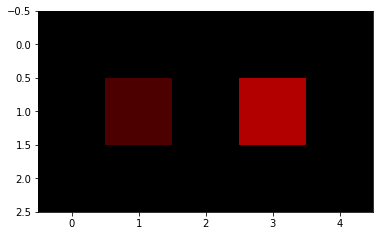

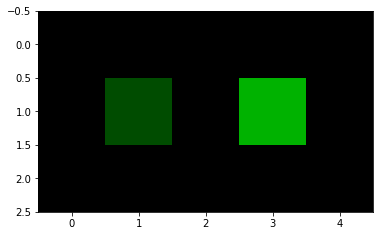

In [9]:
# Settings for domain A (red)
offset_A = 0.3
ratio_A = 0.5
color_A = 0
std_A = 0.05
dataset_A = ColorDataset(offset=offset_A, ratio=ratio_A, color=color_A, std=std_A)
dataloader_A = DataLoader(dataset_A, batch_size=64, shuffle=True)

# Settings for domain B (green)
offset_B = 0.3
ratio_B = 0.5
color_B = 1
std_B = 0.05
dataset_B = ColorDataset(offset=offset_B, ratio=ratio_B, color=color_B, std=std_B)
dataloader_B = DataLoader(dataset_B, batch_size=64, shuffle=True)

visualize_img_batch(dataset_A.example_imgs)
visualize_img_batch(dataset_B.example_imgs)

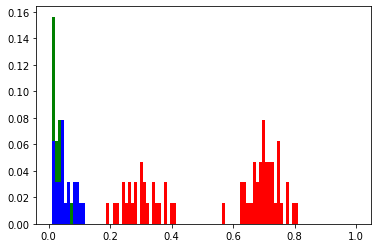

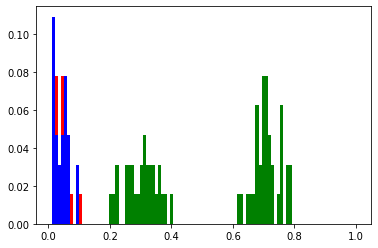

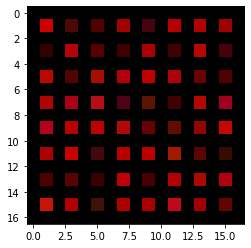

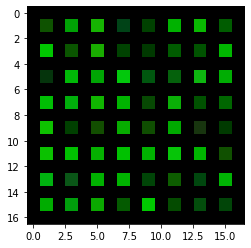

In [10]:
import cv2

def plot_hist(data):
    data = data.permute(1,0,2,3).view(3,-1).cpu()
    for i, c in enumerate(('r', 'g', 'b')):
        plt.hist(data[i], weights=torch.ones(len(data[i]))/len(data[i]), 
                 color=c, bins=100, range= (0.01, 1))
        x_unique_count = torch.stack([(data==x_u).sum() for x_u in data.unique()])
    plt.show()

for i, (data_A, data_B) in enumerate(zip(dataloader_A, dataloader_B)):
#     print('True ratio domain A:', dataloader_A.dataset.ratio)
    plot_hist(data_A)
#     print('True ratio domain B:', dataloader_B.dataset.ratio)
    plot_hist(data_B)
    
    visualize_img_batch(data_A[:64])
    visualize_img_batch(data_B[:64])
    break

## The training loop

In [11]:
# Initialize the networks
weight_network_A = TrivialWeightNet().cuda()
weight_network_B = TrivialWeightNet().cuda()
generator_A = Generator().cuda()
generator_B = Generator().cuda()
discriminator = Discriminator().cuda()

# Initialize the optimizers
lr = 0.001
optimizer_w = optim.Adam(itertools.chain(weight_network_A.parameters(), 
                                         weight_network_B.parameters()), lr=lr)
optimizer_g = optim.Adam(itertools.chain(generator_A.parameters(),
                                         generator_B.parameters()), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Store values
samples_A = []
samples_B = []

losses_g = []
losses_d = []
losses_w = []

Lminusses = []
Lplusses = []

example_importances_A = []
example_importances_B = []

example_d_real = []
example_d_sample = []

penalties = []
variances = []

for epoch in range(1):
    for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):

        real_A = real_A.detach()
        real_B = real_B.detach()
        
        # Generated images
        fake_A = generator_A(real_B)
        fake_B = generator_B(real_A)

        # The weighting process
        w = 0.5*(torch.sigmoid(weight_network_A(real_A)) + torch.sigmoid(-weight_network_B(fake_B.detach())))
        v = 0.5*(torch.sigmoid(-weight_network_A(fake_A.detach())) + torch.sigmoid(weight_network_B(real_B)))

        w = w.cuda()
        v = v.cuda()
        # The loss function --------------------------------------------------------------------------------
        
        # For storing purposes
        Lmin  = (discriminator(real_A, fake_B) * 0.5*(1 + w.detach())).sum().detach()
        Lplus = (discriminator(fake_A, real_B) * 0.5*(1 + v.detach())).sum().detach()
        
        activation_penalty_A = (discriminator(fake_A.detach(), real_B)**2 - 1).sum()
        activation_penalty_B = (discriminator(real_A, real_B.detach())**2 - 1).sum()
        lambda_penalty = 0.01
        
        var_A = ((fake_A - fake_A.mean())**2).sum()
        var_B = ((fake_B - fake_B.mean())**2).sum()
        lambda_var = 0#.01
        
        # The losses that are used for backprop
        # Wants to predict D(fake_A, real_B) = -1, D(real_A, fake_B) = 1
        loss_d = ((discriminator(fake_A.detach(), real_B)) * 0.5*(1 + v.detach())).sum() - \
                 ((discriminator(real_A, fake_B.detach())) * 0.5*(1 + w.detach())).sum() + \
                 lambda_penalty*(activation_penalty_A + activation_penalty_B)

        loss_w = (((discriminator(real_A, fake_B.detach())).detach() * 0.5*(1 + w)).sum() - \
                 ((discriminator(fake_A.detach(), real_B)).detach() * 0.5*(1 + v)).sum())**2
        
        # Wants to predict D(fake_A, real_B) = 1, D(real_A, fake_B) = -1
        loss_g = (discriminator(real_A, fake_B) * 0.5*(1 + w.detach())).sum() - \
                 (discriminator(fake_A, real_B) * 0.5*(1 + v.detach())).sum() - \
                 lambda_var * (var_A + var_B)

        # ---------------------------------------------------------------------------------------------------

        # Backward
        
#         optimizer_w.zero_grad()
#         loss_w.backward()
#         optimizer_w.step()       
        
        # The generator and discriminator distinct loops
#         if i % 6 == 0:
#             optimizer_g.zero_grad()
#             loss_g.backward()
#             optimizer_g.step()
#         else:
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Store values --------------------------------------------------------------------------------------
        Lminusses += [Lmin.item()]
        Lplusses += [Lplus.item()]
        
        losses_g += [loss_g.item()]
        losses_d += [loss_d.item()]
        losses_w += [loss_w.item()]
        
        penalties += [(activation_penalty_A.item(), activation_penalty_B.item())]
        variances += [(var_A.item(), var_B.item())]
        
        w_a = weight_network_A(dataset_A.example_imgs)
        w_b = weight_network_B(dataset_B.example_imgs)
        example_importances_A += [(w_a[0].item(), w_a[1].item())] # Store examples in a list
        example_importances_B += [(w_b[0].item(), w_b[1].item())] # Store examples in a list
        
        d_r1 = discriminator(dataset_A.example_imgs[0].cuda(), dataset_B.example_imgs[0].cuda())
        d_r2 = discriminator(dataset_A.example_imgs[1].cuda(), dataset_B.example_imgs[1].cuda())              
        example_d_real += [(d_r1.item(), d_r2.item())] # Store examples in a list

        d_a = discriminator(real_A[0], fake_B[0])
        d_b = discriminator(fake_A[0], real_B[0])   
        example_d_sample += [(d_a.item(), d_b.item())] # Store examples in a list
        
        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 500 == 0:
            samples_A += [fake_A.detach().cpu()]
            samples_B += [fake_B.detach().cpu()]
            print('step', i, 'loss_g: ', loss_g.item(), 'loss_d: ', loss_d.item(), 'loss_w: ', loss_w.item())

step 0 loss_g:  -0.013454437255859375 loss_d:  -0.7779558897018433 loss_w:  0.00018102188187185675
step 500 loss_g:  74.09586334228516 loss_d:  -74.12242889404297 loss_w:  5490.19677734375
step 1000 loss_g:  370.8358154296875 loss_d:  -357.80841064453125 loss_w:  137519.203125
step 1500 loss_g:  634.8087158203125 loss_d:  -600.0848999023438 loss_w:  402982.09375
step 2000 loss_g:  841.7467041015625 loss_d:  -782.311767578125 loss_w:  708537.5
step 2500 loss_g:  1011.7433471679688 loss_d:  -931.6655883789062 loss_w:  1023624.625
step 3000 loss_g:  1166.585205078125 loss_d:  -1065.363037109375 loss_w:  1360921.0
step 3500 loss_g:  1313.912109375 loss_d:  -1191.4974365234375 loss_w:  1726365.0
step 4000 loss_g:  1457.313232421875 loss_d:  -1310.6107177734375 loss_w:  2123761.75
step 4500 loss_g:  1596.9364013671875 loss_d:  -1426.9637451171875 loss_w:  2550205.75
step 5000 loss_g:  1734.7510986328125 loss_d:  -1539.24072265625 loss_w:  3009361.25
step 5500 loss_g:  1871.4248046875 loss_d:

KeyboardInterrupt: 

In [12]:
weight_network_A = weight_network_A.eval().cpu()
weight_network_B = weight_network_B.eval().cpu()
generator_A = generator_A.eval().cpu()
generator_B = generator_B.eval().cpu()
discriminator = discriminator.eval().cpu()

for i, (real_A, real_B) in enumerate(zip(dataloader_A, dataloader_B)):
    # Generated images
    fake_A = generator_A(real_B.cpu())
    fake_B = generator_B(real_A.cpu())
    break

### Interpretation

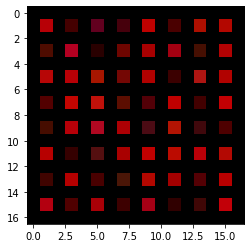

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


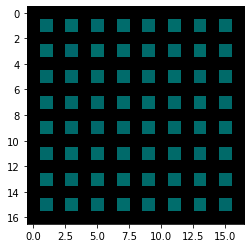

True ratio domain A 0.5


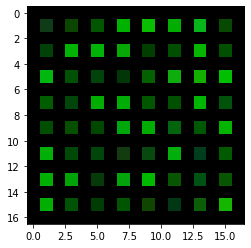

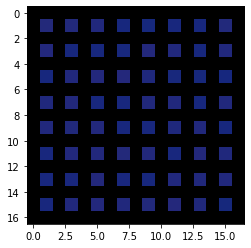

True ratio domain B 0.5


In [13]:
visualize_img_batch(real_A[:64])
visualize_img_batch(fake_B.detach()[:64])
print('True ratio domain A {}'.format(ratio_A))
# plot_hist(real_A)

visualize_img_batch(real_B[:64])
visualize_img_batch(fake_A.detach()[:64])
print('True ratio domain B {}'.format(ratio_B))
# plot_hist(real_B)

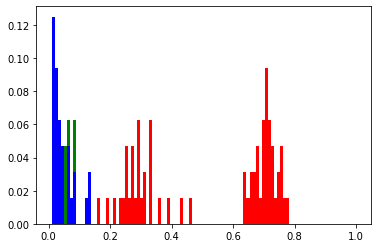

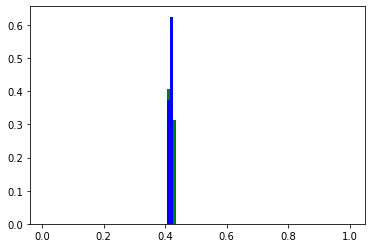

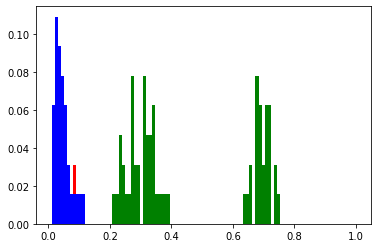

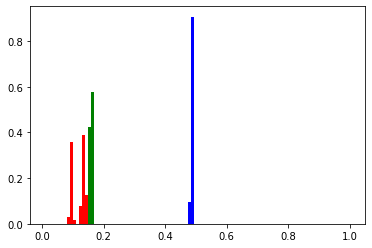

In [14]:
plot_hist(real_A)
plot_hist(fake_B.detach())

plot_hist(real_B)
plot_hist(fake_A.detach())

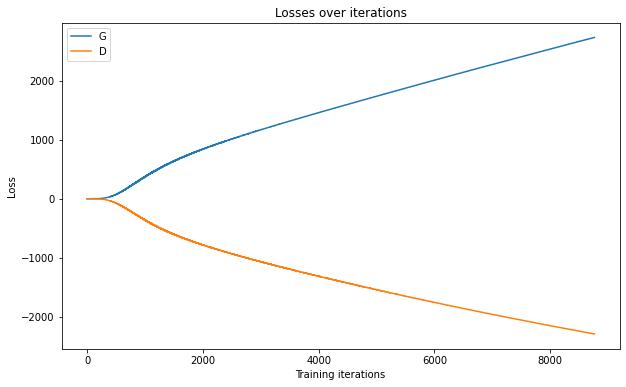

In [15]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_g)
plt.plot(losses_d)
plt.legend(['G', 'D'])
plt.show()

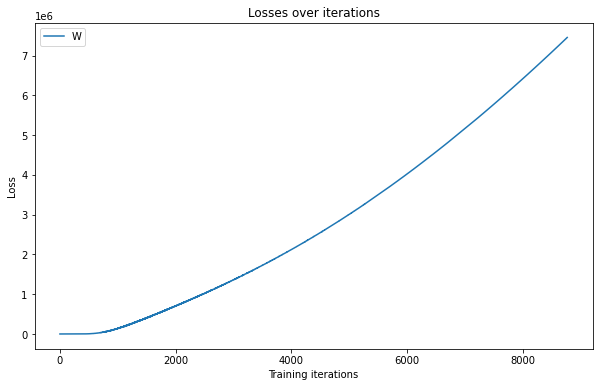

In [16]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
# plt.yscale('symlog')
plt.plot(losses_w)
plt.legend(['W'])
plt.show()

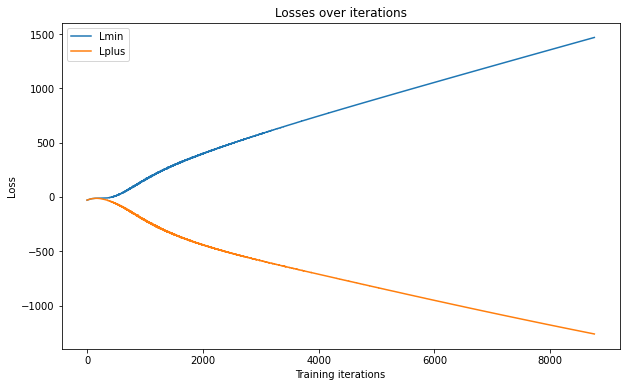

In [17]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(Lminusses)
plt.plot(Lplusses)
plt.legend(['Lmin', 'Lplus'])
plt.show()

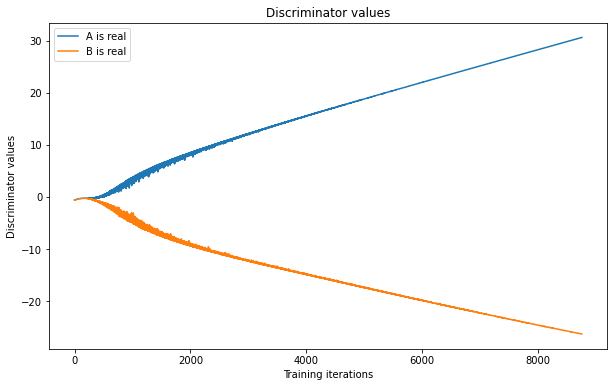

In [18]:
plt.figure(figsize=(10,6))
plt.title('Discriminator values')
plt.plot(torch.Tensor(example_d_sample)[:, 0])
plt.plot(torch.Tensor(example_d_sample)[:, 1])
plt.legend(['A is real', 'B is real'])
plt.ylabel('Discriminator values')
plt.xlabel('Training iterations')
plt.show()

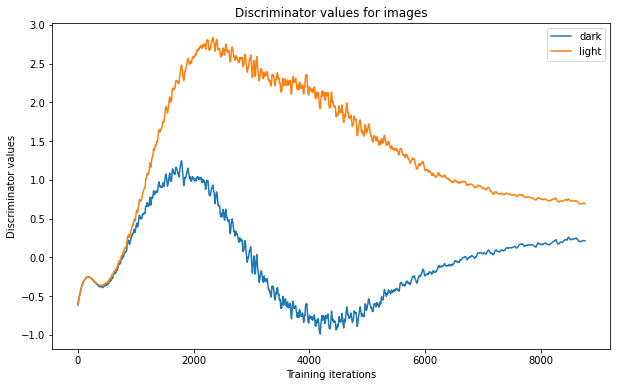

In [19]:
plt.figure(figsize=(10,6))
plt.title('Discriminator values for images')
plt.plot(torch.Tensor(example_d_real)[:, 0])
plt.plot(torch.Tensor(example_d_real)[:, 1])
plt.legend(['dark', 'light'])
plt.ylabel('Discriminator values')
plt.xlabel('Training iterations')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Assigned importances for the toy example images over the course of training')
plt.plot(example_importances_A)
plt.plot(example_importances_B)
plt.legend(['Img A with value {} (p={})'.format(offset_A, ratio_A), 
            'Img A with value {} (p={})'.format(1-offset_A, 1-ratio_A), 
            'Img B with value {} (p={})'.format(offset_B, ratio_B), 
            'Img B with value {} (p={})'.format(1-offset_B, 1-ratio_B)])
plt.ylabel('Assigned importance')
plt.xlabel('Training iterations')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Ratio between importances of the same mode')
plt.plot(torch.Tensor(example_importances_A)[:, 0]/torch.Tensor(example_importances_B)[:, 0])
plt.plot(torch.Tensor(example_importances_A)[:, 1]/torch.Tensor(example_importances_B)[:, 1])
plt.legend(['Dark images', 'Light images'])
plt.ylabel('Ratio importance')
plt.xlabel('Training iterations')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Penalties')
plt.plot(torch.Tensor(penalties)[:, 0])
plt.plot(torch.Tensor(penalties)[:, 1])
plt.legend(['A', 'B'])
plt.ylabel('Discriminator penalties')
plt.xlabel('Training iterations')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Variances')
plt.plot(torch.Tensor(variances)[:, 0])
plt.plot(torch.Tensor(variances)[:, 1])
plt.legend(['A', 'B'])
plt.ylabel('Generator variance')
plt.xlabel('Training iterations')
plt.show()

In [ ]:
for img in samples_A:
#     visualize_img_batch(img[:64])
    plot_hist(img)

In [ ]:
for img in samples_B:
#     visualize_img_batch(img[:64])
    plot_hist(img)